# Music Genre Classification

In this project, I have used the [GTZAN](http://marsyas.info/downloads/datasets.html) dataset, which contains audio files and image representations of these audio files, to perform music genre classification.

> ## Environment Creation

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.models as models
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import librosa
import librosa.feature
import librosa.display
import glob
from matplotlib import pyplot as plt

In [3]:
!pip install jovian --upgrade --quiet

import jovian
jovian.reset()

In [4]:
DATA_DIR = '../input/gtzan-dataset-music-genre-classification/Data/'
genres_path = DATA_DIR + 'genres_original/'
images_path = DATA_DIR + 'images_original/'

## Exploratory Data Analysis

In [5]:
def display_mfcc(song):
   y, _ = librosa.load(song)
   mfcc = librosa.feature.mfcc(y)

   plt.figure(figsize=(10, 4))
   librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
   plt.colorbar()
   plt.title(song)
   plt.tight_layout()
   plt.show()

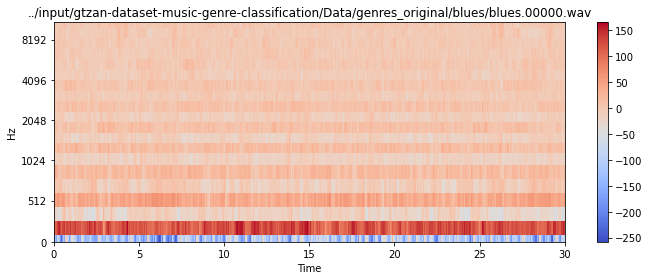

In [6]:
display_mfcc(genres_path + 'blues/blues.00000.wav')

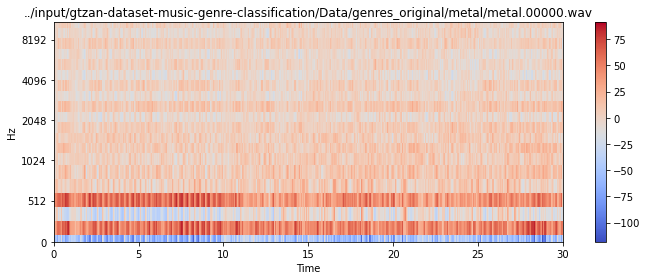

In [7]:
display_mfcc(genres_path + 'metal/metal.00000.wav')

## Data and Model Preparation

### Using Audio Files

In [8]:
def extract_features_song(song):
    y, _ = librosa.load(song)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:25000]

In [9]:
def generate_features_and_labels():
    '''
    Produce MFCC values and genre names 
    from all the songs in the dataset
    '''
    
    # Prepare a list for all the features and all the labels
    all_features = []
    all_labels = []

    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    # Extract features and genre names from each song
    for genre in genres:
        sound_files = glob.glob(genres_path + genre + '/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for i, song in enumerate(sound_files):
        
            # Handle corrupt song 
            if 'jazz.00054.wav' in song:
                features = extract_features_song(sound_files[i - 1])
            else:
                features = extract_features_song(song)
                
            all_features.append(features)

    return np.stack(all_features)

In [10]:
features = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [11]:
labels = np.zeros(1000)
index = 0
for i in range(1000):
    if i % 100 == 0:
        index += 1
    labels[i] = index
labels -= 1

In [12]:
features = features.astype('float32')
labels = labels.astype('int64')

In [13]:
from torch.utils.data import TensorDataset, DataLoader

features_tensor = torch.from_numpy(features)
labels_tensor = torch.from_numpy(labels)
dataset = TensorDataset(features_tensor, labels_tensor)

In [14]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [800, 200])

len(train_ds), len(val_ds)

(800, 200)

In [15]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, num_workers = 2, pin_memory = True)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()    
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

In [17]:
for xb, yb in train_loader:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([32, 25000])
torch.Size([32])


### Using Image Files

In [72]:
img_data = ImageFolder(root = images_path, transform=transforms.Compose([
                               transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [73]:
img_train_ds, img_val_ds = random_split(img_data, [800, 199])

In [74]:
batch_size = 32

img_train_dl = DataLoader(img_train_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
img_val_dl = DataLoader(img_val_ds, batch_size = batch_size, num_workers = 2, pin_memory = True)

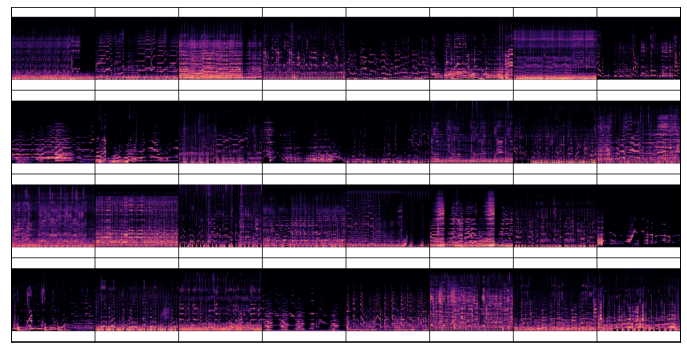

In [75]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(img_train_dl)

In [76]:
img_train_loader = DeviceDataLoader(img_train_dl, device)
img_val_loader = DeviceDataLoader(img_val_dl, device)

In [77]:
for xb, yb in img_train_loader:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


## Base Class and Fit Function

In [78]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class SongClassificationBase(nn.Module):
    
    def training_step(self, batch):
        songs, labels = batch 
        out = self(songs)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        songs, labels = batch 
        out = self(songs)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [79]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Logistic Regression

In [80]:
class LogReg(SongClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(25000, 10)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out

In [81]:
model0 = to_device(LogReg(), device)

In [82]:
epochs = 15
max_lr = 3e-4
opt_func = torch.optim.Adam
grad_clip = 1e-2
weight_decay = 1e-4

In [29]:
%%time
history0 = fit_one_cycle(epochs, max_lr, model0, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 2.2464, val_loss: 2.1828, val_acc: 0.2634
Epoch [1], train_loss: 2.0562, val_loss: 1.9823, val_acc: 0.2679
Epoch [2], train_loss: 1.8043, val_loss: 1.7674, val_acc: 0.4107
Epoch [3], train_loss: 1.6255, val_loss: 1.6262, val_acc: 0.4777
Epoch [4], train_loss: 1.4471, val_loss: 1.5939, val_acc: 0.4464
Epoch [5], train_loss: 1.3167, val_loss: 1.5242, val_acc: 0.4598
Epoch [6], train_loss: 1.1916, val_loss: 1.4673, val_acc: 0.4732
Epoch [7], train_loss: 1.1127, val_loss: 1.5037, val_acc: 0.4821
Epoch [8], train_loss: 1.0567, val_loss: 1.4304, val_acc: 0.5134
Epoch [9], train_loss: 1.0110, val_loss: 1.4342, val_acc: 0.4911
Epoch [10], train_loss: 0.9636, val_loss: 1.4225, val_acc: 0.5089
Epoch [11], train_loss: 0.9364, val_loss: 1.4572, val_acc: 0.4911
Epoch [12], train_loss: 0.9139, val_loss: 1.4249, val_acc: 0.4955
Epoch [13], train_loss: 0.9055, val_loss: 1.4308, val_acc: 0.5179
Epoch [14], train_loss: 0.9015, val_loss: 1.4307, val_acc: 0.5045
CPU times: user 1.79

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

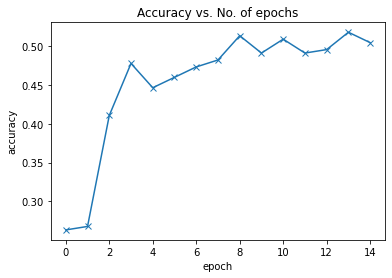

In [30]:
accuracies = [result['val_acc'] for result in history0]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [31]:
torch.save(model0.state_dict(), 'project-LogReg.pth')

jovian.log_hyperparams(arch='LogReg', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

jovian.log_metrics(val_loss=history0[-1]['val_loss'], 
                   val_acc=history0[-1]['val_acc'],
                   train_loss=history0[-1]['train_loss'])

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.
[jovian] Metrics logged.


## Simple Feedforward Neural Network
Feedforward neural network with 6 layers.

In [32]:
class FNN(SongClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
                        nn.Linear(25000, 1024),
                        nn.ReLU(inplace = True),
                        nn.Linear(1024, 512),
                        nn.ReLU(inplace = True),
                        nn.Linear(512, 256),
                        nn.ReLU(inplace = True),
                        nn.Linear(256, 128),
                        nn.ReLU(inplace = True),
                        nn.Linear(128, 64),
                        nn.ReLU(inplace = True),
                        nn.Linear(64, 10)
        )
    
    def forward(self, xb):
        out = self.model(xb)
        return out

In [33]:
model1 = to_device(FNN(), device)

In [34]:
history1 = [evaluate(model1, val_loader)]
history1

[{'val_loss': 2.301589250564575, 'val_acc': 0.1026785746216774}]

In [35]:
epochs = 15
max_lr = 3e-4
opt_func = torch.optim.Adam
grad_clip = 1e-2
weight_decay = 1e-4

In [36]:
%%time
history1 += fit_one_cycle(epochs, max_lr, model1, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 2.3015, val_loss: 2.2934, val_acc: 0.1027
Epoch [1], train_loss: 2.2616, val_loss: 2.1716, val_acc: 0.3259
Epoch [2], train_loss: 2.0459, val_loss: 1.8368, val_acc: 0.3839
Epoch [3], train_loss: 1.7302, val_loss: 1.6683, val_acc: 0.3839
Epoch [4], train_loss: 1.5172, val_loss: 1.5996, val_acc: 0.4420
Epoch [5], train_loss: 1.3936, val_loss: 1.6135, val_acc: 0.4420
Epoch [6], train_loss: 1.4088, val_loss: 1.5588, val_acc: 0.4420
Epoch [7], train_loss: 1.2087, val_loss: 1.5574, val_acc: 0.4911
Epoch [8], train_loss: 1.0305, val_loss: 1.5116, val_acc: 0.4911
Epoch [9], train_loss: 0.9078, val_loss: 1.5779, val_acc: 0.5134
Epoch [10], train_loss: 0.7975, val_loss: 1.5957, val_acc: 0.4866
Epoch [11], train_loss: 0.7083, val_loss: 1.5769, val_acc: 0.5223
Epoch [12], train_loss: 0.6523, val_loss: 1.5916, val_acc: 0.5223
Epoch [13], train_loss: 0.6229, val_loss: 1.5942, val_acc: 0.5089
Epoch [14], train_loss: 0.6115, val_loss: 1.5955, val_acc: 0.5223
CPU times: user 3.07

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

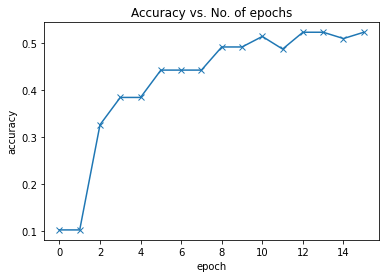

In [37]:
accuracies = [result['val_acc'] for result in history1]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [38]:
torch.save(model1.state_dict(), 'project-6lFNN.pth')

In [39]:
jovian.log_hyperparams(arch='6l FNN', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [40]:
jovian.log_metrics(val_loss=history1[-1]['val_loss'], 
                   val_acc=history1[-1]['val_acc'],
                   train_loss=history1[-1]['train_loss'])

[jovian] Metrics logged.


## Convolutional Neural Network

In [41]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [83]:
class CNN(SongClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 112 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 56 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 28 x 8 x 8
            
            nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.Conv2d(2048, 4096, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 14 x 4 x 4

            nn.Flatten(), 
            nn.Linear(14 * 4 * 4, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),,
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Linear(64, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)

SyntaxError: invalid syntax (<ipython-input-83-6114d854e002>, line 39)

In [43]:
model2 = to_device(CNN(), device)
model2.apply(weights_init)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [44]:
history2 = [evaluate(model2, img_val_loader)]
history2

[{'val_loss': 2.30857253074646, 'val_acc': 0.0982142835855484}]

In [45]:
epochs = 30
max_lr = 3e-4
opt_func = torch.optim.Adam
grad_clip = 1e-2
weight_decay = 1e-4

In [46]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, img_train_loader, img_val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 2.3042, val_loss: 2.3086, val_acc: 0.0982
Epoch [1], train_loss: 2.2808, val_loss: 2.2971, val_acc: 0.1033
Epoch [2], train_loss: 2.1893, val_loss: 2.2637, val_acc: 0.1926
Epoch [3], train_loss: 2.0654, val_loss: 1.9021, val_acc: 0.2685
Epoch [4], train_loss: 2.0251, val_loss: 2.9252, val_acc: 0.1384
Epoch [5], train_loss: 1.8674, val_loss: 2.2569, val_acc: 0.3023
Epoch [6], train_loss: 1.8123, val_loss: 2.8476, val_acc: 0.2462
Epoch [7], train_loss: 1.7357, val_loss: 1.9392, val_acc: 0.3138
Epoch [8], train_loss: 1.6392, val_loss: 1.9901, val_acc: 0.3361
Epoch [9], train_loss: 1.6717, val_loss: 1.8244, val_acc: 0.3737
Epoch [10], train_loss: 1.7199, val_loss: 1.7989, val_acc: 0.3004
Epoch [11], train_loss: 1.5965, val_loss: 1.6895, val_acc: 0.3603
Epoch [12], train_loss: 1.4673, val_loss: 2.4279, val_acc: 0.3023
Epoch [13], train_loss: 1.4716, val_loss: 1.5616, val_acc: 0.4120
Epoch [14], train_loss: 1.4025, val_loss: 2.6378, val_acc: 0.3112
Epoch [15], train_lo

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

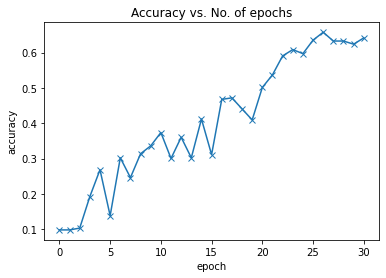

In [47]:
accuracies = [result['val_acc'] for result in history2]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [48]:
torch.save(model2.state_dict(), 'project-CNN.pth')

jovian.log_hyperparams(arch='CNN', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

jovian.log_metrics(val_loss=history2[-1]['val_loss'], 
                   val_acc=history2[-1]['val_acc'],
                   train_loss=history2[-1]['train_loss'])

[jovian] Hyperparams logged.
[jovian] Metrics logged.


## Resnet 34

In [49]:
class ResNet(SongClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [50]:
model3 = to_device(ResNet(), device)
model3.apply(weights_init)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [51]:
history3 = [evaluate(model3, img_val_loader)]
history3

[{'val_loss': 20977431871488.0, 'val_acc': 0.08737244457006454}]

In [52]:
model3.freeze()

In [53]:
%%time
epochs = 10
history3 += fit_one_cycle(epochs, max_lr, model3, img_train_loader, img_val_loader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 2.2585, val_loss: 6.4915, val_acc: 0.1033
Epoch [1], train_loss: 1.7453, val_loss: 2.3584, val_acc: 0.2551
Epoch [2], train_loss: 1.7433, val_loss: 2.9138, val_acc: 0.1390
Epoch [3], train_loss: 1.5833, val_loss: 2.2459, val_acc: 0.2883
Epoch [4], train_loss: 1.5491, val_loss: 2.7266, val_acc: 0.2283
Epoch [5], train_loss: 1.3695, val_loss: 1.9073, val_acc: 0.3852
Epoch [6], train_loss: 1.2092, val_loss: 1.5477, val_acc: 0.4585
Epoch [7], train_loss: 1.0248, val_loss: 1.3398, val_acc: 0.6084
Epoch [8], train_loss: 0.8851, val_loss: 1.2331, val_acc: 0.5638
Epoch [9], train_loss: 0.7548, val_loss: 1.1779, val_acc: 0.6110
CPU times: user 11.2 s, sys: 1.17 s, total: 12.4 s
Wall time: 40.7 s


In [54]:
model3.unfreeze()

In [55]:
%%time
history3 += fit_one_cycle(15, max_lr, model3, img_train_loader, img_val_loader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 0.8221, val_loss: 1.3069, val_acc: 0.5657
Epoch [1], train_loss: 0.8006, val_loss: 1.5771, val_acc: 0.5210
Epoch [2], train_loss: 0.9803, val_loss: 4.4447, val_acc: 0.2347
Epoch [3], train_loss: 1.3491, val_loss: 2.2683, val_acc: 0.3291
Epoch [4], train_loss: 1.2374, val_loss: 3.4525, val_acc: 0.2417
Epoch [5], train_loss: 1.2074, val_loss: 1.7407, val_acc: 0.4745
Epoch [6], train_loss: 1.1816, val_loss: 2.9152, val_acc: 0.3151
Epoch [7], train_loss: 0.9301, val_loss: 1.2760, val_acc: 0.5772
Epoch [8], train_loss: 0.7867, val_loss: 2.9997, val_acc: 0.2570
Epoch [9], train_loss: 0.6592, val_loss: 1.5473, val_acc: 0.5389
Epoch [10], train_loss: 0.4977, val_loss: 1.2991, val_acc: 0.5925
Epoch [11], train_loss: 0.3352, val_loss: 1.2875, val_acc: 0.6422
Epoch [12], train_loss: 0.2472, val_loss: 1.2547, val_acc: 0.6754
Epoch [13], train_loss: 0.1923, val_loss: 1.1350, val_acc: 0.6798
Epoch [14], train_loss: 0.1453, val_loss: 1.1087, val_acc: 0.7136
CPU times: user 16.7

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

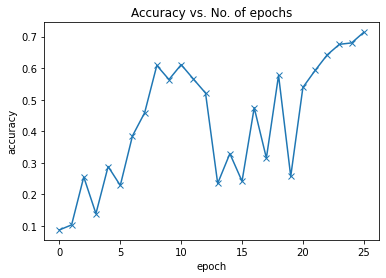

In [56]:
accuracies = [result['val_acc'] for result in history3]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [57]:
torch.save(model3.state_dict(), 'project-Resnet.pth')

jovian.log_hyperparams(arch='Resnet34', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

jovian.log_metrics(val_loss=history3[-1]['val_loss'], 
                   val_acc=history3[-1]['val_acc'],
                   train_loss=history3[-1]['train_loss'])

[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [58]:
jovian.commit(project='genre-classify', environment=None, 
              outputs=['project-LogReg.pth','project-6lFNN.pth','project-CNN.pth','project-Resnet.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/qasimkhan5x/genre-classify


<IPython.core.display.Javascript object>

In [99]:
from torchvision.models import vgg19_bn

In [106]:
class VGG(SongClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg19_bn(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Linear(num_ftrs, 10)

    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [110]:
vgg_model = to_device(VGG(), device)

In [111]:
history4 = [evaluate(vgg_model, img_val_loader)]
history4

[{'val_loss': 2.332064151763916, 'val_acc': 0.11862244457006454}]

In [112]:
%%time
epochs = 10
history4 += fit_one_cycle(epochs, max_lr, vgg_model, img_train_loader, img_val_loader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 2.0627, val_loss: 1.5950, val_acc: 0.4452
Epoch [1], train_loss: 1.1907, val_loss: 1.2487, val_acc: 0.6690
Epoch [2], train_loss: 0.9613, val_loss: 1.9427, val_acc: 0.6129
Epoch [3], train_loss: 0.8633, val_loss: 2.6640, val_acc: 0.5459
Epoch [4], train_loss: 0.6465, val_loss: 1.8581, val_acc: 0.6148
Epoch [5], train_loss: 0.4926, val_loss: 1.1477, val_acc: 0.6620
Epoch [6], train_loss: 0.3014, val_loss: 1.2907, val_acc: 0.6665
Epoch [7], train_loss: 0.1456, val_loss: 1.2346, val_acc: 0.7226
Epoch [8], train_loss: 0.0871, val_loss: 1.2720, val_acc: 0.7404
Epoch [9], train_loss: 0.0493, val_loss: 1.1868, val_acc: 0.7404
CPU times: user 46.8 s, sys: 33.2 s, total: 1min 20s
Wall time: 1min 42s


In [113]:
from torchvision.models import densenet121

In [116]:
class DenseNet(SongClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.densenet121(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, 10)

    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [117]:
dn_model = to_device(DenseNet(), device)

In [118]:
history5 = [evaluate(dn_model, img_val_loader)]
history5

[{'val_loss': 2.425715923309326, 'val_acc': 0.0714285746216774}]

In [119]:
%%time
epochs = 15
history5 += fit_one_cycle(epochs, max_lr, dn_model, img_train_loader, img_val_loader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 2.2176, val_loss: 2.1350, val_acc: 0.2213
Epoch [1], train_loss: 1.5671, val_loss: 1.5626, val_acc: 0.5185
Epoch [2], train_loss: 0.9520, val_loss: 1.1195, val_acc: 0.6327
Epoch [3], train_loss: 0.6133, val_loss: 1.1568, val_acc: 0.5969
Epoch [4], train_loss: 0.3759, val_loss: 1.2059, val_acc: 0.6327
Epoch [5], train_loss: 0.2416, val_loss: 0.9996, val_acc: 0.6843
Epoch [6], train_loss: 0.2056, val_loss: 0.8372, val_acc: 0.7207
Epoch [7], train_loss: 0.1619, val_loss: 1.0328, val_acc: 0.7315
Epoch [8], train_loss: 0.0821, val_loss: 0.9785, val_acc: 0.7181
Epoch [9], train_loss: 0.0404, val_loss: 0.7961, val_acc: 0.7564
Epoch [10], train_loss: 0.0229, val_loss: 0.7657, val_acc: 0.7966
Epoch [11], train_loss: 0.0188, val_loss: 0.7517, val_acc: 0.7876
Epoch [12], train_loss: 0.0153, val_loss: 0.7176, val_acc: 0.8099
Epoch [13], train_loss: 0.0134, val_loss: 0.7312, val_acc: 0.7876
Epoch [14], train_loss: 0.0154, val_loss: 0.7269, val_acc: 0.7742
CPU times: user 1min

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

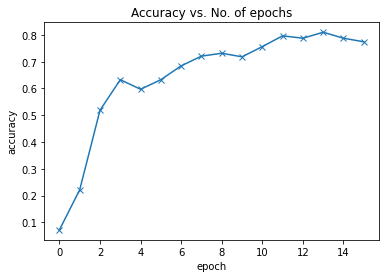

In [120]:
accuracies = [result['val_acc'] for result in history5]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [ ]:
jovian.commit(project='genre-classify', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/qasimkhan5x/genre-classify


<IPython.core.display.Javascript object>

# Conclusion

In this project, I used the GTZAN dataset to train 4 deep learning models to classify the genre of songs. I achieved the highest accuracy using resnet34 which was about 67%. However, the state of the art accuracy is about 90% which was achieved in this [paper](https://arxiv.org/ftp/arxiv/papers/1906/1906.11620.pdf) by Bian et al. In their paper, they used another dataset as well as the DenseNet model. So, future work should focus on the DenseNet to achieve greater accuracy.